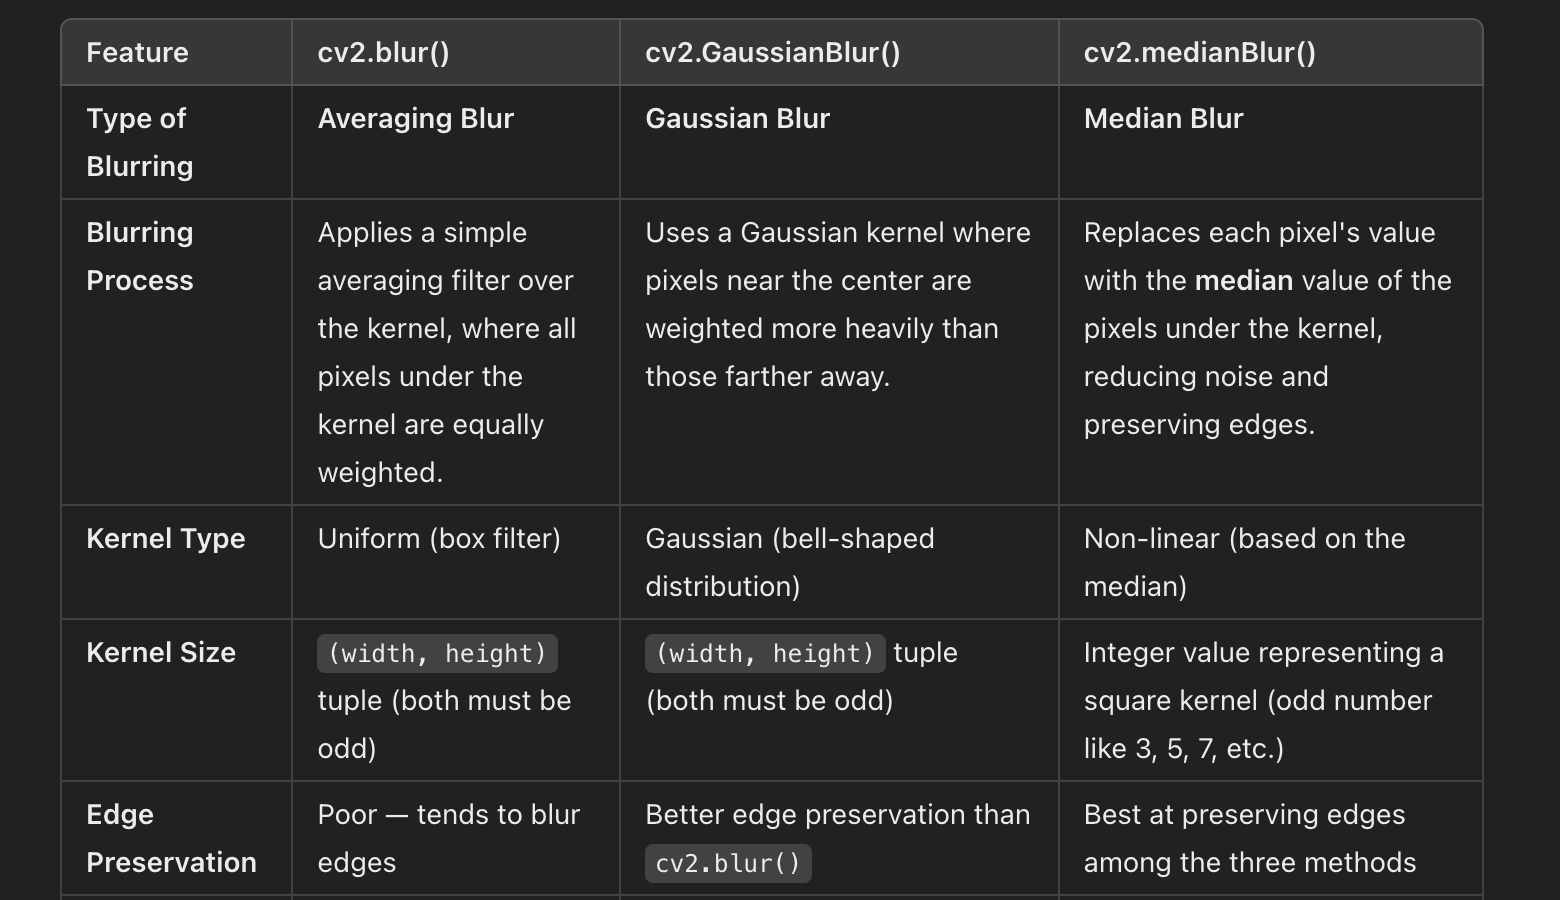

In [29]:
def blur_type(img,filter_type="blur",kernel=13):
    if filter_type == "blur":
        return cv2.blur(img,(kernel,kernel))
    if filter_type == "gaussian":
        return cv2.GaussianBlur(img,(kernel,kernel),0)
    if filter_type == "median":
        return cv2.medianBlur(img,kernel)

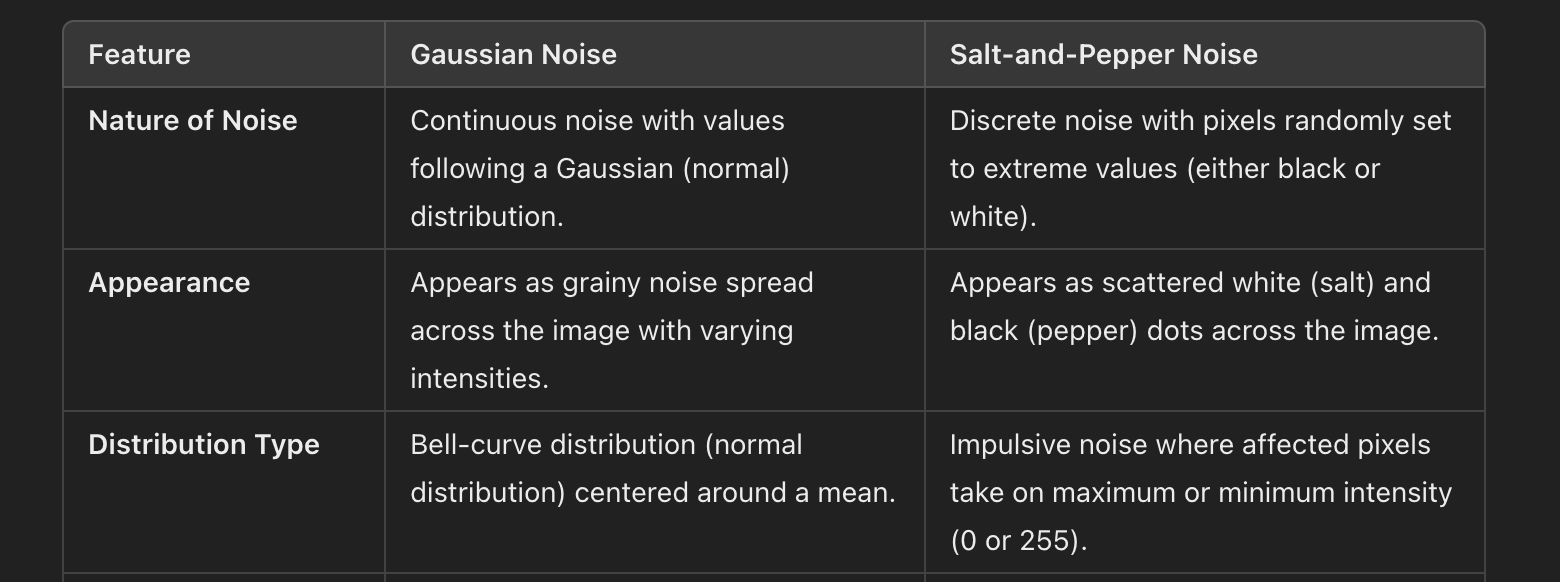

In [30]:
def add_noise(img,noise_type="gauss"):
    if noise_type == "gauss":
        mean = 0
        st = 0.5
        gauss = np.random.normal(mean,st,img.shape)
        gauss = gauss.astype("uint8")
        image = cv2.add(img,gauss)
        return image
    elif noise_type == "sp":
        prob = 0.01
        black = np.array([0,0,0],dtype="uint8")
        white = np.array([255,255,255],dtype="uint8")
        probs = np.random.random(img.shape[:2])
        img[probs < (prob/2)] = black
        img[probs > 1-(prob/2)] = white
        return img

In [31]:
def filp(img,flip_code):
    filped_image = cv2.flip(img,flip_code)
    return filped_image

In [32]:
def data_agumentaion(img):
    returned_augs = dict()
    AUGS = ["Blure","Noise","Flip"]
    random_num = random.randint(1,3)
    random_choice = random.choices(AUGS,k=random_num)
    for choices in random_choice:
        if choices == "Blure":
            filters = ["blur","gaussian","median"]
            kernals = [5,7,9,11]
            random_filter = random.choices(filters,k=1)[0]
            random_kernal = random.choices(kernals,k=1)[0]
            blured_image = blur_type(img,filter_type=random_filter,kernel=random_kernal)
            new_image = "_blured"
            returned_augs[new_image] = blured_image
        elif choices == "Noise":
            noises = ["gauss","sp"]
            random_noise = random.choices(noises,k=1)[0]
            nosied_image = add_noise(img,noise_type=random_noise)
            new_image = "_noised"
            returned_augs[new_image] = nosied_image
        elif choices == "Flip":
            flip_codes = [-1,0,1]
            random_code = random.choices(flip_codes,k=1)[0]
            flipped_image = filp(img,flip_code=random_code)
            new_image = "_flipped_image"
            returned_augs[new_image] = flipped_image
    return returned_augs

In [33]:
import os
from tqdm import tqdm
import cv2
import random    
import numpy as np

In [34]:
for folder in os.listdir("/kaggle/input/blood-cell-cancer-all-4class/Blood cell Cancer [ALL]"):
    folder_path = os.path.join("/kaggle/input/blood-cell-cancer-all-4class/Blood cell Cancer [ALL]",folder)
    for img_name in tqdm(os.listdir(folder_path)):
        img_path = os.path.join(folder_path,img_name)
        img = cv2.imread(img_path)
        returned = data_agumentaion(img)
        for expoted_name , exporated_image in returned.items():
            new_name = img_name.split(".")[0] + expoted_name + "." + img_name.split(".")[-1]
            new_path = os.path.join(folder_path,new_name)
            cv2.imwrite(new_path,exporated_image)

100%|██████████| 512/512 [00:57<00:00,  8.90it/s]


In [48]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

In [50]:
transforms = transforms.Compose([transforms.Resize(128),transforms.ToTensor()])

In [51]:
ds = ImageFolder(root="/kaggle/input/blood-cell-cancer-all-4class/Blood cell Cancer [ALL]",transform=transforms)
loader = DataLoader(ds,batch_size=8,shuffle=True)

In [53]:
train_size = int(0.8*len(ds))
test_size = len(ds) - train_size
train_ds , test_ds = random_split(ds,[train_size , test_size])

In [54]:
train_loader = DataLoader(train_ds,batch_size=8,shuffle=True)
test_loader = DataLoader(test_ds,batch_size=8,shuffle=True)

In [57]:
from torchvision.models import googlenet, GoogLeNet_Weights
model = googlenet(weights=GoogLeNet_Weights)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 190MB/s]


In [58]:
model

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [62]:
import torch.nn as nn
model.fc = nn.Sequential(nn.Linear(in_features=1024,out_features=512),
                        nn.ReLU(),
                        nn.Dropout(0.2),
                        nn.Linear(in_features=512,out_features=128),
                        nn.ReLU(),
                        nn.Dropout(0.2),
                        nn.Linear(in_features=128,out_features=64),
                        nn.ReLU(),
                        nn.Dropout(0.2),
                        nn.Linear(in_features=64,out_features=4))

In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [67]:
import torch.optim as optim
from sklearn.metrics import f1_score, accuracy_score

criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [71]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0, verbose=False):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

def train_model(model, train_loader, optimizer, criterion, device, test_loader, num_epochs=10, patience=7):
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    best_model_state = None
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_preds = []
        all_labels = []
        
        for batch_idx, (inputs, labels) in enumerate(tqdm(train_loader, desc=f'Training Epoch {epoch + 1}/{num_epochs}', leave=False)):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = accuracy_score(all_labels, all_preds)
        epoch_f1 = f1_score(all_labels, all_preds, average='weighted')
        print(f'Epoch [{epoch + 1}/{num_epochs}] Training Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}, F1 Score: {epoch_f1:.4f}')
        
        # Evaluate on test set and check for early stopping
        val_loss = test_model(model, test_loader, criterion, device)
        
        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
        
        # Early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f'Early stopping triggered at epoch {epoch + 1}')
            break
    
    # Load the best model state
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f'Loaded best model with validation loss: {best_val_loss:.4f}')

def test_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Testing', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_loss = running_loss / len(test_loader)
    test_accuracy = accuracy_score(all_labels, all_preds)
    test_f1 = f1_score(all_labels, all_preds, average='weighted')
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1:.4f}')
    
    return test_loss

# Training and testing the model
num_epochs = 100  # Specify the number of epochs
patience = 7     # Number of epochs to wait before early stopping
train_model(model, train_loader, optimizer, criterion, device, test_loader, num_epochs, patience)

Epoch [1/10] Training Loss: 0.1427, Accuracy: 0.9610, F1 Score: 0.9610


Test Loss: 0.0451, Test Accuracy: 0.9892, Test F1 Score: 0.9892


Epoch [2/10] Training Loss: 0.0894, Accuracy: 0.9788, F1 Score: 0.9788


Test Loss: 0.0894, Test Accuracy: 0.9815, Test F1 Score: 0.9815
EarlyStopping counter: 1 out of 7


Epoch [3/10] Training Loss: 0.0948, Accuracy: 0.9753, F1 Score: 0.9753


Test Loss: 0.0318, Test Accuracy: 0.9938, Test F1 Score: 0.9938


Epoch [4/10] Training Loss: 0.0686, Accuracy: 0.9799, F1 Score: 0.9799


Test Loss: 0.0911, Test Accuracy: 0.9738, Test F1 Score: 0.9743
EarlyStopping counter: 1 out of 7


Epoch [5/10] Training Loss: 0.0635, Accuracy: 0.9811, F1 Score: 0.9811


Test Loss: 0.0716, Test Accuracy: 0.9784, Test F1 Score: 0.9784
EarlyStopping counter: 2 out of 7


Epoch [6/10] Training Loss: 0.1107, Accuracy: 0.9718, F1 Score: 0.9718


Test Loss: 0.1991, Test Accuracy: 0.9214, Test F1 Score: 0.9149
EarlyStopping counter: 3 out of 7


Epoch [7/10] Training Loss: 0.0523, Accuracy: 0.9846, F1 Score: 0.9846


Test Loss: 0.0228, Test Accuracy: 0.9969, Test F1 Score: 0.9969


Epoch [8/10] Training Loss: 0.0699, Accuracy: 0.9842, F1 Score: 0.9842


Test Loss: 0.0279, Test Accuracy: 0.9861, Test F1 Score: 0.9860
EarlyStopping counter: 1 out of 7


Epoch [9/10] Training Loss: 0.0789, Accuracy: 0.9823, F1 Score: 0.9823


Test Loss: 0.0322, Test Accuracy: 0.9938, Test F1 Score: 0.9939
EarlyStopping counter: 2 out of 7


Epoch [10/10] Training Loss: 0.0997, Accuracy: 0.9757, F1 Score: 0.9757


Test Loss: 0.0160, Test Accuracy: 0.9985, Test F1 Score: 0.9985
Loaded best model with validation loss: 0.0160
